# torch와 torchvision 라이브러리를 이용하여 Fashion MNIST에서의 Classification

## 사용할 라이브러리 호출

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## 데이터셋 로드 및 전처리
- 데이터셋은 normalize만 적용
- train dataset과 test dataset을 각각 trainloader, testloader에 load
- torchvision.dataset.FashionMNIST( )를 이용

In [ ]:
# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(), #PIL이미지를 텐서로 변환해야함
    #텐서로 변환하지 않으면 모델학습에서 TypeError발생
    transforms.Normalize((0.5, ), (0.5,))
    #(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)로하면 3채널이라서
    #outputs = net(inputs)에서 오류남
])
#참고: https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html

# write your code
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testset =  torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)
#참고: https://resultofeffort.tistory.com/95
#참고: https://yceffort.kr/2019/02/13/pytorch-fashion-MNIST

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

100%|██████████| 26421880/26421880 [00:13<00:00, 1941066.50it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203293.36it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3732865.15it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5936837.23it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## 신경망 정의
- 2개의 convolution layer와 3개의 fc layer를 사용
- 활성화 함수는 ReLU 사용

In [ ]:
# 신경망 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  #'hint: ~(~,class_num)'
        #fc3의 입력차원 == fc2의 출력차원, 클래스 10개니까 10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) #'hint: conv2'
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) #'hint: fc2'
        x = self.fc3(x)
        return x


## Loss, optimizer 정의
- loss는 crossEntropy를 사용
- optimizer는 SGD를 사용

In [ ]:
# 신경망 생성 및 손실 함수, 최적화 함수 정의

net = Net()
criterion = nn.CrossEntropyLoss() #다중분류에 사용되는 손실함수
optimizer = optim.SGD(net.parameters(), momentum=0.9)
#경사하강법
#momentum: 이전 업데이트를 현재 업데이트에 일정비율로 반영함. -> local minimum에 빠지는 것 방지
#참고: https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html

In [ ]:
print(len(trainloader))

15000


## 모델 학습
- 2 epoch만큼 반복
- Gradient는 iteration마다 초기화해야함
- 역전파를 위해 backward() 함수 사용

In [ ]:
# 2 epoch만큼 반복
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Gradient 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = net(inputs) #Conv2d(1, 6, 5)니까 채널은 1이다.
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 1.376
[1,  4000] loss: 0.680
[1,  6000] loss: 0.568
[1,  8000] loss: 0.515
[1, 10000] loss: 0.470
[1, 12000] loss: 0.455
[1, 14000] loss: 0.419
[2,  2000] loss: 0.383
[2,  4000] loss: 0.385
[2,  6000] loss: 0.378
[2,  8000] loss: 0.374
[2, 10000] loss: 0.350
[2, 12000] loss: 0.368
[2, 14000] loss: 0.352


## 모델 저장 및 평가
- 학습된 모델을 불러와서 평가를 진행
- 평가는 test dataset을 사용

In [ ]:
# 모델 저장
PATH = './fashion_net.pth'
torch.save(net.state_dict(), PATH)

# 테스트 데이터로 모델 평가
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        # 입력 받기
        images, labels = data
        outputs = net(images)
        # 최대값 출력
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


Accuracy of the network on the 10000 test images: 86 %


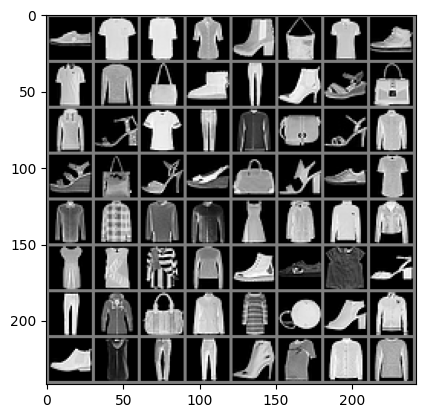

GroundTruth:  Sneaker T-shirt/top Shirt Shirt
Predicted:  Sneaker T-shirt/top Shirt Shirt


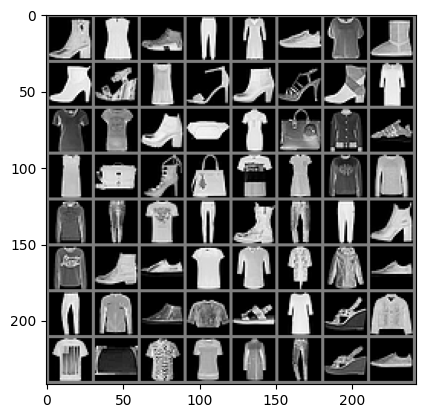

GroundTruth:  Ankle boot Shirt Sneaker Trouser
Predicted:  Ankle boot Shirt Ankle boot Trouser


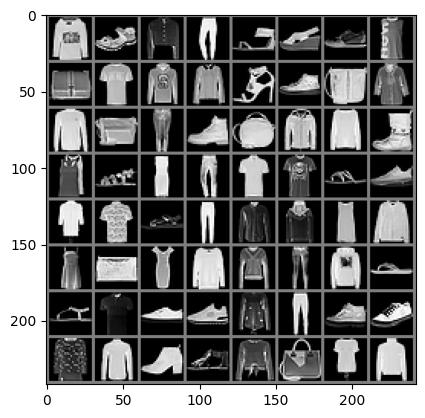

GroundTruth:  Pullover Sandal Shirt Trouser
Predicted:  Pullover Sandal  Coat Trouser


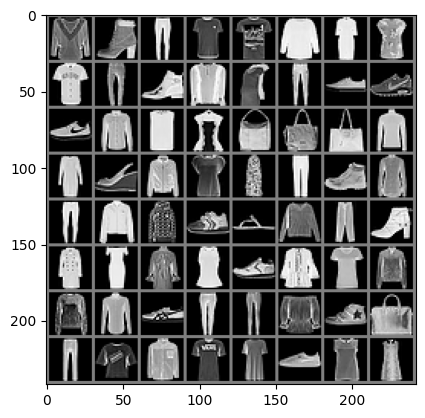

GroundTruth:  Pullover Ankle boot Trouser T-shirt/top
Predicted:  Pullover Ankle boot Trouser T-shirt/top


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 시각화
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(testloader)


for i in range(4):
    images, labels = next(dataiter)


    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

# 실습 과제 2

- 실습 내용
1. MMdetection 설치 및 환경 구성
2. 2nd stage detector인 Mask R-CNN을 MMdetection 환경에서 불러오고 instance segmentation 추론 실습
3. 1st stage detector인 DETR을 MMdetection 환경에서 불러오고 object detection 추론 실습

## 1. MMDetection 설치 및 환경 구성


In [ ]:
!pip install -U openmim
!mim install "mmengine>=0.7.0"
!pip install "mmcv==2.1.0"

Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.2.0/index.html
  Using cached mmcv-2.1.0.tar.gz (471 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for mmcv: filename=mmcv-2.1.0-cp310-cp310-linux_x86_64.whl size=38057303 sha256=e128cf47807505c9390092a4a4c8a4f7bdeb187014e2d436be2387f33a14dc3d
  Stored in directory: /root/.cache/pip/wheels/8b/09/35/94a7f7ba6a00e3810abd0492340e4cbba0ff3d443120a94120
Successfully built mmcv


In [ ]:
# mmdetection 설치
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -e .

Cloning into 'mmdetection'...
remote: Enumerating objects: 38019, done.
remote: Total 38019 (delta 0), reused 0 (delta 0), pack-reused 38019
Receiving objects: 100% (38019/38019), 63.17 MiB | 29.13 MiB/s, done.
Resolving deltas: 100% (26236/26236), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmdet


In [ ]:
# Version check

import torch, torchvision
print("torch version:",torch.__version__, "cuda:",torch.cuda.is_available())


import mmdet
print("mmdetection:",mmdet.__version__)

import mmcv
print("mmcv:",mmcv.__version__)


import mmengine
print("mmengine:",mmengine.__version__)


torch version: 2.2.1+cu121 cuda: True
mmdetection: 3.3.0
mmcv: 2.1.0
mmengine: 0.10.4


## 2. Mask R-CNN Detector

### 개요

- Mask R-CNN은 이미지에서 객체를 탐지하여 바운딩 박스(bounding box)를 추출하고, 각 객체가 이미지에서 어떤 픽셀을 차지하고 있는지를 검출하여 instance segmentation 과업도 수행하는 하는 합성곱 신경망(CNN) 기반 2-stage detector입니다.

- Mask R-CNN은 RoI Pooling에서 발전한 형태인 RoI Align 구조를 채택하여, 이미지에서 더 정확한 특징 추출이 가능합니다.

- Mask R-CNN 구조 그림은 아래에서 확인하실 수 있으며, 더 자세한 내용은 paper를 확인해 주세요.


참조 :

[paper](https://arxiv.org/abs/1703.06870)

<img src="https://user-images.githubusercontent.com/40661020/143967081-c2552bed-9af2-46c4-ae44-5b3b74e5679f.png" alt="mask rcnn" align="bottom" />






### Mask R-CNN 체크포인트 다운로드

In [ ]:
!mim download mmdet --config mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco --dest ./checkpoints

processing mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 MiB 12.4 MB/s eta 0:00:00
Successfully downloaded mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth to /content/mmdetection/checkpoints
Successfully dumped mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py to /content/mmdetection/checkpoints


In [ ]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
# config 파일 불러오기
config_file = '/content/mmdetection/checkpoints/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

register_all_modules()

# config 파일과 체크포인트 파일을 모델에 입력하고 초기화
model = init_detector(config_file, checkpoint_file, device='cuda:0')


Loads checkpoint by local backend from path: /content/mmdetection/checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


### 예제 사진을 불러오고 Mask R-CNN 추론하기

- 'inference detector' API를 불러와서 과제 파일에서 제공한 그림으로 직접 추론을 진행합니다.
- 코드 참조 : https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/inference.py#L15

In [ ]:
# 이미지 불러오기
image = mmcv.imread('/content/1.png')
# 추론 진행
result = inference_detector(model, image)

### 결과 시각화하기

In [ ]:
from mmdet.registry import VISUALIZERS
# 시각화 도구 초기화
visualizer = VISUALIZERS.build(model.cfg.visualizer)
visualizer.dataset_meta = model.dataset_meta

/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


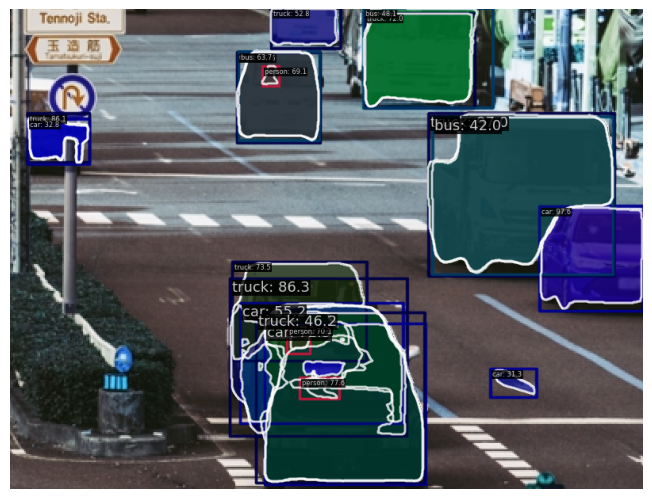

In [ ]:
# 결과 시각화
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt = None,
    wait_time=0,
)
visualizer.show()

## 2. DETR Detector

### 개요

- DETR은 Transformer를 backbone 으로 사용한 모델 입니다.

- DETR은 Attention 을 활용하며 여러개의 object queries 를 사용해 이미지에 object를 매칭해 학습합니다.

- DETR구조 그림은 아래에서 확인하실 수 있으며, 더 자세한 내용은 paper를 확인해 주세요.


참조 :
[paper](https://arxiv.org/abs/2005.12872)

<img src="https://user-images.githubusercontent.com/40661020/143878072-0a7434e4-416b-4315-aeea-a8297f4d6453.png" alt="DETR" align="bottom" />


In [ ]:
# write your code
# hint : wget , github mmdetection/configs/detr/ weight 존재
!wget https://raw.githubusercontent.com/open-mmlab/mmdetection/main/configs/detr/detr_r50_8xb2-150e_coco.py

--2024-05-13 16:03:50--  https://raw.githubusercontent.com/open-mmlab/mmdetection/main/configs/detr/detr_r50_8xb2-150e_coco.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5433 (5.3K) [text/plain]
Saving to: ‘detr_r50_8xb2-150e_coco.py.1’

detr_r50_8xb2-150e_ 100%[===================>]   5.31K  --.-KB/s    in 0s      

2024-05-13 16:03:50 (54.0 MB/s) - ‘detr_r50_8xb2-150e_coco.py.1’ saved [5433/5433]



In [ ]:
!mim download mmdet --config detr_r50_8xb2-150e_coco --dest ./checkpoints

processing detr_r50_8xb2-150e_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.8/564.8 MiB 27.7 MB/s eta 0:00:00
Successfully downloaded detr_r50_8xb2-150e_coco_20221023_153551-436d03e8.pth to /content/mmdetection/checkpoints
Successfully dumped detr_r50_8xb2-150e_coco.py to /content/mmdetection/checkpoints


In [ ]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules

# config 파일 불러오기
config_file = '/content/mmdetection/checkpoints/detr_r50_8xb2-150e_coco.py'
# 사전학습 모델 체크포인트 불러오기
checkpoint_file = '/content/mmdetection/checkpoints/detr_r50_8xb2-150e_coco_20221023_153551-436d03e8.pth'
# 모든 모듈을 등록
register_all_modules()

# config 파일과 체크포인트 파일을 모델에 입력하고 초기화
model = init_detector(config_file, checkpoint_file, device='cuda:0')


Loads checkpoint by local backend from path: /content/mmdetection/checkpoints/detr_r50_8xb2-150e_coco_20221023_153551-436d03e8.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std



In [ ]:
# 이미지 불러오기
image = mmcv.imread('/content/1.png')
# 추론 진행
result = inference_detector(model, image)
# print(result)

In [ ]:
from mmdet.registry import VISUALIZERS
# 시각화 도구 초기화
visualizer = VISUALIZERS.build(model.cfg.visualizer)
visualizer.dataset_meta = model.dataset_meta

/usr/local/lib/python3.10/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:760: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:831: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(


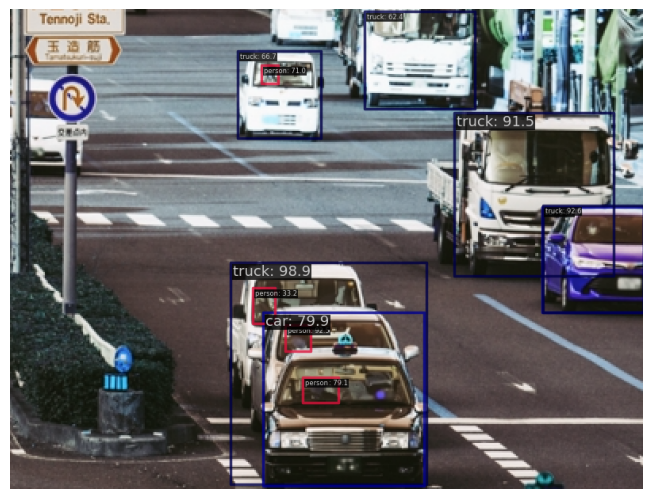

In [ ]:
# 결과 시각화
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt = None,
    wait_time=0,
)
visualizer.show()

In [ ]:





#

In [ ]:
# 결과 시각화
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt = None,
    wait_time=0,
)
visualizer.show()

In [ ]:
# 결과 시각화
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt = None,
    wait_time=0,
)
visualizer.show()